In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.4870 - loss: nan - val_accuracy: 0.5167 - val_loss: nan
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.5007 - loss: nan - val_accuracy: 0.5167 - val_loss: nan
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4985 - loss: nan - val_accuracy: 0.5167 - val_loss: nan
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.4976 - loss: nan - val_accuracy: 0.5167 - val_loss: nan
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5154 - loss: nan - val_accuracy: 0.5167 - val_loss: nan
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.4850 - loss: nan - val_accuracy: 0.5167 - val_loss: nan
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.4299 - loss: nan - val_accuracy: 0.5167 - val_loss: nan
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5050 - loss: nan - val_accuracy: 0.5167 - val_loss: nan
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accura

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


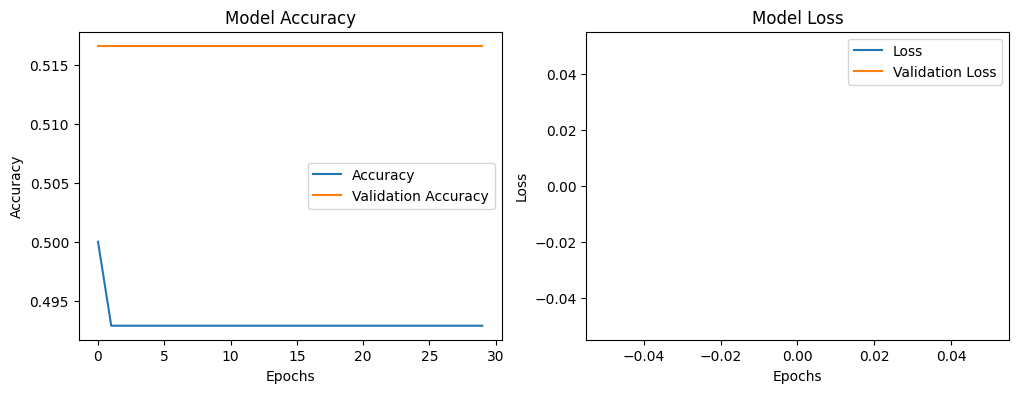

In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
import time

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'

# Load data
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=0)  # Epileptic
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=1)  # Healthy

# Combine data and labels
if data_Epileptic.size > 0 and data_Healthy.size > 0:
    data_all = np.concatenate((data_Epileptic, data_Healthy), axis=0)
    labels_all = np.concatenate((labels_Epileptic, labels_Healthy), axis=0)

    # Convert labels to one-hot encoding
    labels_all_one_hot = to_categorical(labels_all, num_classes=2)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all_one_hot, test_size=0.3, random_state=42)

    # Reshape to 3D for CNN-LSTM input
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Define the CNN-LSTM model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128, activation='relu', return_sequences=False),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Binary classification
    ])

    # Compile the model (no optimizer, using default SGD with learning rate)
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()  # Start time for training duration
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    end_time = time.time()  # End time for training duration
    training_duration = end_time - start_time  # Training time duration

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
    y_test_classes = np.argmax(y_test, axis=1)

    # Compute metrics
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')  # Weighted recall
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Weighted): ", recall)
    print("Test Precision (Weighted): ", precision)
    print("Test F1 Score (Weighted): ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training Duration (in seconds): ", training_duration)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


With Standerscaler

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.5388 - loss: 0.6894 - val_accuracy: 0.4833 - val_loss: 0.6926
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.5390 - loss: 0.6887 - val_accuracy: 0.4667 - val_loss: 0.6925
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.4091 - loss: 0.7026 - val_accuracy: 0.5167 - val_loss: 0.6924
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5280 - loss: 0.6960 - val_accuracy: 0.5000 - val_loss: 0.6923
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.4707 - loss: 0.6951 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.5000 - loss: 0.6955 - val_accuracy: 0.5167 - val_loss: 0.6920
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5403 - loss: 0.6898 - val_accuracy: 0.5000 - val_loss: 0.6919
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.5325 - loss: 0.6912 - val_accuracy: 0.5167 - val_loss: 0.6917
Epoch 9/

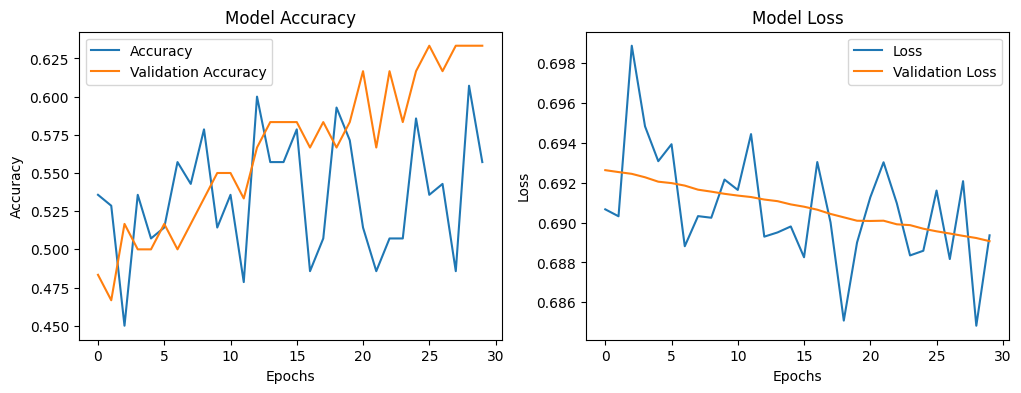

In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
import time

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'

# Load data
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=0)  # Epileptic
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=1)  # Healthy

# Combine data and labels
if data_Epileptic.size > 0 and data_Healthy.size > 0:
    data_all = np.concatenate((data_Epileptic, data_Healthy), axis=0)
    labels_all = np.concatenate((labels_Epileptic, labels_Healthy), axis=0)

    # StandardScaler preprocessing
    scaler = StandardScaler()
    data_all_scaled = scaler.fit_transform(data_all)

    # Convert labels to one-hot encoding
    labels_all_one_hot = to_categorical(labels_all, num_classes=2)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all_scaled, labels_all_one_hot, test_size=0.3, random_state=42)

    # Reshape to 3D for CNN-LSTM input
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Define the CNN-LSTM model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128, activation='relu', return_sequences=False),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Binary classification
    ])

    # Compile the model (no custom optimizer, default SGD used)
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()  # Start time for training duration
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    end_time = time.time()  # End time for training duration
    training_duration = end_time - start_time  # Training time duration

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
    y_test_classes = np.argmax(y_test, axis=1)

    # Compute metrics
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')  # Weighted recall
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Weighted): ", recall)
    print("Test Precision (Weighted): ", precision)
    print("Test F1 Score (Weighted): ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training Duration (in seconds): ", training_duration)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5089 - loss: 0.7262 - val_accuracy: 0.4667 - val_loss: 0.6857
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5616 - loss: 0.6703 - val_accuracy: 0.6333 - val_loss: 0.6641
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6125 - loss: 0.6553 - val_accuracy: 0.6500 - val_loss: 0.6515
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6652 - loss: 0.6268 - val_accuracy: 0.6333 - val_loss: 0.6333
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6969 - loss: 0.6022 - val_accuracy: 0.6333 - val_loss: 0.6140
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7327 - loss: 0.5942 - val_accuracy: 0.7167 - val_loss: 0.6041
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7080 - loss: 0.5671 - val_accuracy: 0.6500 - val_loss: 0.5792
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8144 - loss: 0.5116 - val_accuracy: 0.7000 - val_loss: 0.5457
Epoch 9/30

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step

Final Evaluation Metrics:
Test Accuracy:  0.9
Test Recall (Sensitivity):  0.7931034482758621
Test Precision:  1.0
Test F1 Score:  0.8846153846153846
Test Specificity:  1.0
Confusion Matrix: 
 [[31  0]
 [ 6 23]]
Training time:  309.0689694881439


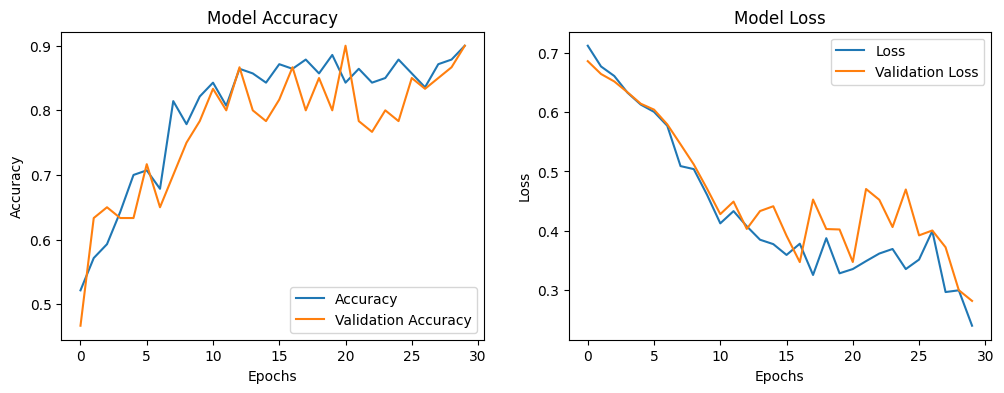

In [4]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import time
from tensorflow.keras.optimizers import Adam

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (Z)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (N)

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic), axis=0)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Reshape data for LSTM input (samples, time_steps, features)
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Define the CNN-LSTM model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (0 or 1)
    ])

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    training_time = time.time() - start_time

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Print metrics
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test F1 Score: ", f1)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training time: ", training_time)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


Both op and standerscaler

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5412 - loss: 0.6892 - val_accuracy: 0.4500 - val_loss: 0.7011
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5043 - loss: 0.6886 - val_accuracy: 0.5167 - val_loss: 0.7021
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5358 - loss: 0.6842 - val_accuracy: 0.5167 - val_loss: 0.7059
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.6640 - loss: 0.6559 - val_accuracy: 0.5167 - val_loss: 0.7113
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6429 - loss: 0.6535 - val_accuracy: 0.5333 - val_loss: 0.6896
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6910 - loss: 0.6437 - val_accuracy: 0.6500 - val_loss: 0.6586
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6767 - loss: 0.6310 - val_accuracy: 0.7167 - val_loss: 0.6397
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7146 - loss: 0.5876 - val_accuracy: 0.6500 - val_loss: 0.5816
Epoch 9/30


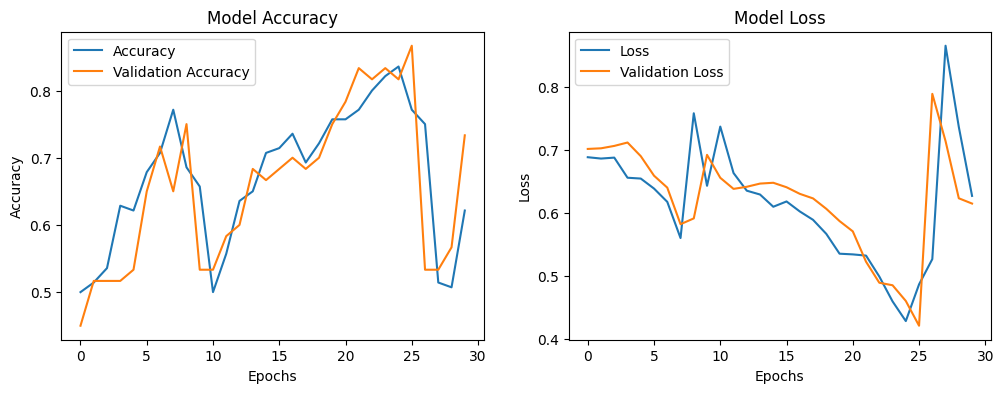

In [5]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import time
from tensorflow.keras.optimizers import Adam

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (Z)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (N)

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic), axis=0)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Apply StandardScaler (only for numerical scaling)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Reshape data for LSTM input (samples, time_steps, features)
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Define the CNN-LSTM model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (0 or 1)
    ])

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    training_time = time.time() - start_time

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Print metrics
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test F1 Score: ", f1)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training time: ", training_time)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")
